In [ ]:
"""
Purpose: Implementation fo DiffPool
graph coarsening manner

"""

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import datajoint as dj
import trimesh
from tqdm.notebook import tqdm
from pathlib import Path

from os import sys
#sys.path.append("/meshAfterParty/meshAfterParty")
sys.path.append("/datasci_tools/datasci_tools")
sys.path.append("/machine_learning_tools/machine_learning_tools/")
sys.path.append("/pytorch_tools/pytorch_tools/")
sys.path.append("/neuron_morphology_tools/neuron_morphology_tools/")

from importlib import reload

In [3]:
data_path = Path("./data/m65_full/")
list(data_path.iterdir())

[PosixPath('data/m65_full/cell_type_fine_with_skeleton'),
 PosixPath('data/m65_full/df_morphometrics.pbz2'),
 PosixPath('data/m65_full/cell_type_fine_with_skeleton_no_dense'),
 PosixPath('data/m65_full/df_cell_type_fine.pbz2')]

In [4]:
#datasci_tools modules
import system_utils as su
import pandas_utils as pu
import pandas as pd
import numpy as np
import numpy_utils as nu
import networkx_utils as xu
from tqdm_utils import tqdm

#neuron_morphology_tools modules
import neuron_nx_io as nxio

In [5]:
import torch
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges
from torch_geometric.data import Data
from torch_geometric import transforms

# for the dataset object
from torch_geometric.data import InMemoryDataset, download_url
from torch_geometric.loader import DataLoader
from torch_geometric.data import DenseDataLoader

In [6]:
#pytorch_tools modules
import preprocessing_utils as pret
import geometric_models as gm

# Step 0: Choosing the Model

In [9]:
model_name = "DiffPoolGCN"
model_class = getattr(gm,model_name)
dense_adj = getattr(model_class,"dense_adj",False)
directed = getattr(model_class,"directed",False)
print(f"dense_adj= {dense_adj}, directed = {directed}")

gnn_task = "cell_type_fine"
label_name = None
graph_label = "cell_type_fine_label"
data_file = "df_cell_type_fine.pbz2"

dense_adj= True, directed = False


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device = {device}")

with_skeleton = True

features_to_delete = [
    "mesh_volume",
    "apical_label",
    "basal_label",
]

if not with_skeleton:
    features_to_delete +=[
        "skeleton_vector_downstream_phi",      
        "skeleton_vector_downstream_theta",    
        "skeleton_vector_upstream_phi",        
        "skeleton_vector_upstream_theta",  
    ]

features_to_keep = None


device = cpu


# Step 1: Loading the Graph Data

In [12]:
data_filepath = Path(data_path) / Path(data_file)

data_df = su.decompress_pickle(data_filepath)
data_df

,segment_id,split_index,nucleus_id,external_layer,external_visual_area,cell_type_fine,cell_type_fine_label
0,864691134277239760,0,89719,LAYER_6,V1,"[{'nodelist': ['L0_0'], 'features': ['mesh_vol...",NaN
1,864691134339067925,0,624899,LAYER_6,AL,"[{'nodelist': ['L0_1', 'L0_0', 'L0_2'], 'featu...",NaN
2,864691134366116139,0,476756,WHITE_MATTER,RL,"[{'nodelist': ['L0_6'], 'features': ['mesh_vol...",NaN
3,864691134378215335,0,3799,LAYER_2/3,V1,"[{'nodelist': ['L0_1', 'L0_0', 'L0_2'], 'featu...",NaN
4,864691134527727930,0,631380,WHITE_MATTER,RL,"[{'nodelist': ['L0_0'], 'features': ['mesh_vol...",NaN
...,...,...,...,...,...,...,...
60448,864691137197334593,0,376218,LAYER_6,V1,"[{'nodelist': ['L0_0', 'L0_1', 'L0_2', 'L0_5',...",NaN
60449,864691137197344065,0,191436,LAYER_2/3,V1,"[{'nodelist': ['L0_0', 'L0_1', 'L0_4', 'L0_6',...",NaN
60450,864691137197345345,0,584463,LAYER_2/3,RL,"[{'nodelist': ['L0_13', 'L4_5', 'L0_8', 'L2_5'...",NaN
60451,864691137197353281,0,591241,LAYER_5,RL,"[{'nodelist': ['L4_6', 'L1_10', 'L3_4', 'L0_10...",NaN


In [13]:
"""
Note the cell_type_fine is the column
that has all of the graph data stored
"""

'\nNote the cell_type_fine is the column\nthat has all of the graph data stored\n'

In [14]:
data_df.query("cell_type_fine_label == cell_type_fine_label")

,segment_id,split_index,nucleus_id,external_layer,external_visual_area,cell_type_fine,cell_type_fine_label
115,864691134884748026,0,366181,LAYER_5,V1,"[{'nodelist': ['L0_10', 'L0_11', 'L0_12', 'L0_...",4P
147,864691134884761338,0,458241,LAYER_4,RL,"[{'nodelist': ['L0_0', 'L0_1', 'L0_2', 'L0_3',...",23P
170,864691134884769786,0,592718,LAYER_5,RL,"[{'nodelist': ['L0_18', 'L0_11', 'L0_17', 'L0_...",5P_IT
205,864691134884879610,0,304873,LAYER_5,V1,"[{'nodelist': ['L2_4', 'L1_1', 'L0_3', 'L1_6',...",IT_short
213,864691134884945146,0,63499,LAYER_2/3,V1,"[{'nodelist': ['L0_0', 'L0_1', 'L0_2', 'L0_3',...",23P
...,...,...,...,...,...,...,...
60416,864691137197239105,0,262000,LAYER_4,V1,"[{'nodelist': ['L0_0', 'L0_1', 'L0_2', 'L0_3',...",4P
60417,864691137197241665,0,308938,LAYER_6,V1,"[{'nodelist': ['L1_4', 'L0_18', 'L4_1', 'L0_16...",Unsure
60433,864691137197306177,0,304611,LAYER_5,V1,"[{'nodelist': ['L0_1', 'L0_3', 'L0_6', 'L0_0',...",5P_NP
60442,864691137197321281,0,434601,LAYER_5,RL,"[{'nodelist': ['L0_3', 'L3_3', 'L2_2', 'L2_3',...",6P


In [15]:
data_dict = data_df[["cell_type_fine"]].iloc[1].to_list()[0][0]
data_dict

{'nodelist': array(['L0_1', 'L0_0', 'L0_2'], dtype=object),
 'features': array(['mesh_volume', 'n_spines', 'n_synapses_head', 'n_synapses_neck',
        'n_synapses_post', 'n_synapses_pre', 'skeletal_length',
        'total_spine_volume', 'width_upstream', 'width_downstream',
        'apical_label', 'basal_label', 'skeleton_vector_downstream_phi',
        'skeleton_vector_downstream_theta', 'skeleton_vector_upstream_phi',
        'skeleton_vector_upstream_theta', 'width_no_spine'], dtype=object),
 'adjacency': array([[0, 1, 1],
        [1, 0, 0],
        [1, 0, 0]]),
 'feature_matrix': array([[ 3.71170715e-03,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.43345470e+03,  0.00000000e+00,  5.91837642e+01,
          5.91837642e+01,  0.00000000e+00,  1.00000000e+00,
         -6.22637047e-01,  2.00297982e+00, -6.22637047e-01,
          2.00297982e+00,  5.91837642e+01],
        [ 2.99289539e+01,  0.00000000e+00,  0.00000000e+00,
    

# Step 2: Creating the Pytorch Dataset

# -- a) Getting Means and Std Dev for Normalization --

In [16]:
all_batch_df = pd.concat([nxio.feature_df_from_gnn_info(
    k[0],
    return_data_labels_split = False) for k in data_df[gnn_task].to_list()])

if label_name is not None:
    all_batch_df = all_batch_df[[k for k in 
            all_batch_df.columns if k not in nu.convert_to_array_like(label_name)]]
else:
    all_batch_df = all_batch_df
    
# will use these to normalize the data
col_means = all_batch_df.mean(axis=0).to_numpy()
col_stds = all_batch_df.std(axis=0).to_numpy()

all_batch_df_norm = pu.normalize_df(all_batch_df,column_means=col_means,
                                 column_stds = col_stds)
all_batch_df_norm.std()

mesh_volume                         1.0
n_spines                            1.0
n_synapses_head                     1.0
n_synapses_neck                     1.0
n_synapses_post                     1.0
n_synapses_pre                      1.0
skeletal_length                     1.0
total_spine_volume                  1.0
width_upstream                      1.0
width_downstream                    1.0
apical_label                        1.0
basal_label                         1.0
skeleton_vector_downstream_phi      1.0
skeleton_vector_downstream_theta    1.0
skeleton_vector_upstream_phi        1.0
skeleton_vector_upstream_theta      1.0
width_no_spine                      1.0
dtype: float64

# --- b) Creating the Dataset Class --

In [17]:
# -- mapping of the labels to integers --
total_labels,label_counts = np.unique((data_df.query(f"{graph_label}=={graph_label}")[
    graph_label]).to_numpy(),return_counts = True)
cell_type_map = {k:i+1 for i,k in enumerate(total_labels)}
cell_type_map[None] = 0
cell_type_map

{'1P': 1,
 '23P': 2,
 '4P': 3,
 '5P_IT': 4,
 '5P_NP': 5,
 '5P_PT': 6,
 '6CT': 7,
 '6P': 8,
 '6P_CT': 9,
 '6P_IT': 10,
 '6P_U': 11,
 'BC': 12,
 'BPC': 13,
 'I targeting non_bpc': 14,
 'IT_big_tuft': 15,
 'IT_short': 16,
 'IT_small_tuft': 17,
 'Martinotti': 18,
 'NGC': 19,
 'Pvalb': 20,
 'SST': 21,
 'Unsure': 22,
 'VIP': 23,
 'WM_P': 24,
 'cb1 basket': 25,
 'chandelier': 26,
 'l1vip': 27,
 'ndnf+npy_': 28,
 'ngfc': 29,
 'prox targeting': 30,
 'small basket': 31,
 None: 0}

In [18]:
#cell_type_map
cell_type_fine_classifier_weights = {
'23P': 0.25,#1294
'4P': 0.3,#890
'5P_IT': 0.5,#465
'6P': 0.8,#342
'6P_IT': 0.8,#263
'5P_PT': 0.8,#224
}


class_idx = np.array(list(cell_type_map.values()) )
class_labels = np.array(list(cell_type_map.keys()) )
weights = np.array([cell_type_fine_classifier_weights.get(k,1) for k in class_labels])
weights = weights[np.argsort(class_idx)]
weights

array([1.  , 1.  , 0.25, 0.3 , 0.5 , 1.  , 0.8 , 1.  , 0.8 , 1.  , 0.8 ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ])

In [19]:
def pytorch_data_from_gnn_info(
    gnn_info,
    y = None,
    verbose = False,
    normalize = True,
    features_to_delete=None,
    features_to_keep = None
    ): 
    """
    Purpose: To convert our data format into pytorch Data object

    Pseudocode: 
    1) Create the edgelist (turn into tensor)
    2) Get the 
    """
    edgelist = torch.tensor(xu.edgelist_from_adjacency_matrix(
        array = gnn_info["adjacency"],
        verbose = False,
    ).T,dtype=torch.long)

    x,y_raw = nxio.feature_df_from_gnn_info(
        gnn_info,
        return_data_labels_split = True)
    if y is None:
        y = y_raw
        
    if not type(y) == str:
        y = None
        
    y_int = np.array(cell_type_map[y] ).reshape(1,-1)
    
    if normalize:
        x = (x-col_means)/col_stds
    
    # --- keeping or not keeping sertain features
    gnn_features = gnn_info["features"]

    keep_idx = np.arange(len(gnn_features))
    if features_to_delete is not None:
        curr_idx = np.array([i for i,k in enumerate(gnn_features)
                       if k not in features_to_delete])
        keep_idx = np.intersect1d(keep_idx,curr_idx)
        if verbose:
            print(f"keep_idx AFTER DELETE= {keep_idx}")
    if features_to_keep is not None:
        curr_idx = np.array([i for i,k in enumerate(gnn_features)
                       if k in features_to_keep])
        keep_idx = np.intersect1d(keep_idx,curr_idx)
        if verbose:
            print(f"keep_idx AFTER KEEP = {keep_idx}")

    x = x[:,keep_idx]

    x = torch.tensor(x,dtype=torch.float)
    y = torch.tensor(y_int,dtype=torch.long)
    
    if len(y) > 1:
        raise Exception(f"y = {y}")
        
    if y.shape[0] != 1 or y.shape[1] != 1:
        raise Exception(f"y = {y}")


    if verbose:
        print(f"x.shape = {x.shape},y.shape ={y.shape}")

    data = Data(x=x,y=y,edge_index=edgelist)
    return data

In [20]:
class CellTypeDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        #return ['some_file_1', 'some_file_2', ...]
        return [str(data_filepath.absolute())]

    @property
    def processed_file_names(self):
        return ['data.pt']

    # def download(self):
    #     # Download to `self.raw_dir`.
    #     download_url(url, self.raw_dir)
    #     ...

    def process(self):
        # Read data into huge `Data` list.
        #data_list = [...]

#         if data_df is None:
#             data_df = su.decompress_pickle(self.raw_file_names[0])

        
        
        data_list = []
        for k,y in tqdm(zip(
            data_df[gnn_task].to_list(),
            data_df[graph_label].to_list())):
            

            if not type(y) == str:
                y = None
            
            if cell_type_map[y] == 0:
                continue
            
            data_list.append(pytorch_data_from_gnn_info(
                k[0],
                y=y,
                features_to_delete=features_to_delete,
                features_to_keep = features_to_keep,
                verbose = False))

        if self.pre_filter is not None:
            data_list_final = []
            for data in data_list:
                try:
                    if self.pre_filter(data):
                        data_list_final.append(data)
                except:
                    continue
                    
            data_list = data_list_final
            
        for j,d in enumerate(data_list):
            if d.y.shape[0] != 1 or d.y.shape[1] != 1:
                raise Exception(f"{j}")

        if self.pre_transform is not None:
            data_list_final = []
            for j,data in enumerate(data_list):
                try:
                    curr_t = self.pre_transform(data)
                    if curr_t.y.shape[0] != 1 or curr_t.y.shape[1] != 1:
                        raise Exception(f"{j}, data = {curr_t}")
                    data_list_final.append(curr_t)
                except:
                    continue
            data_list = data_list_final
            
        for j,d in enumerate(data_list):
            if d.y.shape[0] != 1 or d.y.shape[1] != 1:
                raise Exception(f"{j}, data = {d}")

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [21]:
if with_skeleton:
    gnn_task_name = f"{gnn_task}_with_skeleton"
else:
    gnn_task_name = f"{gnn_task}"

if dense_adj:
    processed_data_folder = data_path / Path(f"{gnn_task_name}")#_processed_dense")
elif directed:
    processed_data_folder = data_path / Path(f"{gnn_task_name}_directed")#_processed_dense")
else:
    processed_data_folder = data_path / Path(f"{gnn_task_name}_no_dense")#_processed_dense")
    
processed_data_folder

PosixPath('data/m65_full/cell_type_fine_with_skeleton')

In [22]:
# try:
#     su.rm_dir(processed_data_folder)
# except:
#     pass

processed_data_folder.mkdir(exist_ok = True)

In [23]:
max_nodes = np.max(all_batch_df_norm.index.to_numpy()) + 1

class MyFilter(object):
    def __call__(self, data):
        return data.num_nodes <= max_nodes
    
if dense_adj:
    #gets the maximum number of nodes in any of the graphs
    transform_list = [
        transforms.ToUndirected(),
        T.ToDense(max_nodes),
        #transforms.NormalizeFeatures(),
    ]
    pre_filter = MyFilter()
elif directed:
    transform_list = []
    pre_filter = None
else:
    transform_list = [
        transforms.ToUndirected(),
    ]
    
    pre_filter = None
    

transform_norm = transforms.Compose(transform_list)
dataset = CellTypeDataset(
        processed_data_folder.absolute(),
        pre_transform = transform_norm,
        pre_filter = pre_filter,
        )

In [24]:
# for j,d in enumerate(dataset):
#     if d.y.shape[0] != 1 or d.y.shape[1] != 1:
#         raise Exception(f"{j}")

In [25]:
dataset_num_node_features = dataset.num_node_features
dataset_num_classes = dataset.num_classes

In [26]:
# looking at the dataset
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset_num_node_features}')
print(f'Number of classes: {dataset_num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
# print(f'Has isolated nodes: {data.has_isolated_nodes()}')
# print(f'Has self-loops: {data.has_self_loops()}')
# print(f'Is undirected: {data.is_undirected()}')


Dataset: CellTypeDataset(3338):
Number of graphs: 3338
Number of features: 14
Number of classes: 32

Data(x=[256, 14], y=[1, 1], adj=[256, 256], mask=[256])
Number of nodes: 256
Number of edges: 0
Average node degree: 0.00


# --- c) Splitting the Data into Labeled and unlabeled

In [27]:
labeled_mask = np.array(
    [True if k.y[0][0] > 0 else False for k in dataset]
).astype('int')
dataset_labeled = dataset[np.where(labeled_mask)[0]]
len(dataset_labeled)

3338

In [28]:
dataset_curr = dataset_labeled
torch.manual_seed(12345)
dataset_curr = dataset_curr.shuffle()

# --- d) Split Train/Validation/Test

In [29]:
"""
Purpose: To turn percentages into raw lengths

"""

'\nPurpose: To turn percentages into raw lengths\n\n'

In [30]:
batch_size = 64

(train_dataset,
val_dataset,
test_dataset,) = pret.train_val_test_split(
    dataset_curr,
    return_dict=False,
    verbose = True)

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')
print(f'Number of val graphs: {len(val_dataset)}')

test size = 667.0 (0.2 %)
validation size = 667.0 (0.2 %)
train_size = 2004.0
data_lengths_with_train = [2004  667  667]
Number of training graphs: 2004
Number of test graphs: 667
Number of val graphs: 667


In [31]:
# # if wanted to try and add weights
# y_train = np.array([int(data.y[0][0].numpy()) for data in train_dataset])
# y_train_classes,y_train_count = np.unique(y_train,return_counts = True)
# y_train_classes,y_train_count

# sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

# weight = {i:1/}
# samples_weight = np.array([weight[t] for t in y_train])
# samples_weight = torch.from_numpy(samples_weight)
# samples_weight

In [32]:
if dense_adj:
    data_loader_mod = DenseDataLoader
else:
    data_loader_mod = DataLoader


train_loader = data_loader_mod(train_dataset, batch_size=batch_size,shuffle = True)
test_loader = data_loader_mod(test_dataset, batch_size=batch_size,shuffle=False)
val_loader = data_loader_mod(val_dataset, batch_size=batch_size,shuffle=False)

/usr/local/lib/python3.6/dist-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DenseDataLoader' is deprecated, use 'loader.DenseDataLoader' instead
  warnings.warn(out)


# Step 3a; Picking the Model

In [98]:
n_epochs = 300


import general_utils as gu
architecture_kwargs_global = dict(
    n_hidden_channels = 32, 
    #n_hidden_channels=64, 
    #first_heads=8, 
    #output_heads=1, 
    #dropout=0.6,
    global_pool_type="mean",
    n_pool_layers = 2,
)

optimizer_kwargs_global = dict(
    lr=0.01
)

all_run_kwargs = [
    dict(architecture_kwargs = dict(n_hidden_channels = 64,n_pool_layers = 1)),
#     dict(architecture_kwargs = dict(n_hidden_channels = 8)),
#     dict(),
#     dict(architecture_kwargs = dict(n_hidden_channels = 64),),
#     dict(architecture_kwargs = dict(n_hidden_channels = 128),),
    
#     dict(architecture_kwargs = dict(n_pool_layers = 1,n_hidden_channels = 8)),
#     dict(architecture_kwargs = dict(n_pool_layers = 1,n_hidden_channels = 32),),
#     dict(architecture_kwargs = dict(n_pool_layers = 1,n_hidden_channels = 64),),
#     dict(architecture_kwargs = dict(n_pool_layers = 1,n_hidden_channels = 128),),
    
    
    
#     dict(architecture_kwargs = dict(n_hidden_channels = 32,global_pool_type="add"),),
#     dict(architecture_kwargs = dict(n_hidden_channels = 16,global_pool_type="add"),),
#     dict(architecture_kwargs = dict(n_hidden_channels = 8,global_pool_type="add"),),
#     dict(architecture_kwargs = dict(n_layers = 1,n_hidden_channels = 32,global_pool_type="add"),),
#     dict(architecture_kwargs = dict(n_layers = 1,n_hidden_channels = 16,global_pool_type="add"),),
#     dict(architecture_kwargs = dict(n_layers = 1,n_hidden_channels = 8,global_pool_type="add"),),

]

# Step 3: Training the Model

In [99]:
import evaluation_utils as evu
import torch.nn.functional as F
import model_utils as mdlu
verbose = True

In [100]:
for j,config_dict in enumerate(all_run_kwargs):
    
    architecture_kwargs = config_dict.get("architecture_kwargs",dict())
    optimizer_kwargs = config_dict.get("optimizer_kwargs",dict())
    
    architecture_kwargs = gu.merge_dicts([architecture_kwargs_global.copy(),architecture_kwargs])
    optimizer_kwargs = gu.merge_dicts([optimizer_kwargs_global.copy(),optimizer_kwargs])
    
    run_kwargs = gu.merge_dicts([architecture_kwargs,optimizer_kwargs])

    
    if verbose:
        print(f"\n\n\n****------ Running Model Config {j} with following parameters ------****\n{run_kwargs}")

    model = getattr(gm,model_name)(
        dataset_num_node_features=dataset_num_node_features,
        dataset_num_classes=dataset_num_classes,
        **architecture_kwargs
        )

    optimizer = torch.optim.Adam(model.parameters(), **optimizer_kwargs)
    print(model)


    
    # ---------------- Configuring the Tensorboard and Checkpoinns--------------------
    from torch.utils.tensorboard import SummaryWriter

    tensorboard_dir = Path("./tensorboard")
    tensorboard_dir.mkdir(exist_ok=True)
    tensorboard_dir = tensorboard_dir / Path(f"{model_name}")
    tensorboard_dir.mkdir(exist_ok=True)

    tensorboard_file_name = (f'{model_name}_' 
                             + "_".join([f"{k}_{v}" for k,v in run_kwargs.items()]))
    tensorboard_file_name += f"_with_skeleton_{with_skeleton}"
    print(f"tensorboard_file_name = {tensorboard_file_name}")
    tensorboard_file = tensorboard_dir / Path(f'{tensorboard_file_name}')
    try:
        su.rm_dir(tensorboard_file)
    except:
        pass
    tensorboard_file.mkdir(exist_ok = True)


    #-- when to save a checkpoint of the model
    checkpoint_dir = Path("./model_checkpoints")
    checkpoint_dir.mkdir(exist_ok = True)
    checkpoint_dir = checkpoint_dir / Path(f"{model_name}")
    checkpoint_dir.mkdir(exist_ok = True)
    checkpoint_path = checkpoint_dir / Path(f"./{tensorboard_file_name}_checkpoints")

    try:
        su.rm_dir(checkpoint_path)
    except:
        pass

    checkpoint_path.mkdir(exist_ok = True)
    n_epoch_for_checkpoint = 5

    writer = SummaryWriter(tensorboard_file)
    

    print(model)


    # weights = weight#[0.1,0.5,,1,0.7,1,1,1]
    # class_weights = None
    class_weights = torch.FloatTensor(weights).to(device)

    tensor_map = None

    def train():
        model.train()

        for data in train_loader:#train_loader:  # Iterate in batches over the training dataset.
            #print(f"data = {data}")
            data = data.to(device)
            if model_name == "DiffPoolGCN":
                out,gnn_loss, cluster_loss = model(data)  # Perform a single forward pass.
                #y_true = data.y.reshape(-1,3)
            elif model_name == "TreeLSTM":
                n = data.x.shape[0]
                h = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
                c = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
                out = model(
                    data,
                    h = h,
                    c = c,
                    embeddings = data.x
                    )
            else:
                out = model(data)
            y_true = data.y.squeeze_()
            #print(f"out.shape = {out.shape}, data.y.shape = {data.y.shape}")
            loss = F.nll_loss(
                torch.log(out), y_true,
                weight = class_weights,
            )  # Compute the loss.
            loss.backward()  # Derive gradients.
            optimizer.step()  # Update parameters based on gradients.
            optimizer.zero_grad()  # Clear gradients.
            return loss


    def test(loader,verbose = False):
        model.eval()
        y_pred_list = []
        y_true_list = []
        for data in loader:  # Iterate in batches over the training/test dataset.
            data = data.to(device)
            if model_name == "DiffPoolGCN":
                out,gnn_loss, cluster_loss = model(data)  # Perform a single forward pass.
                #y_true = data.y.reshape(-1,3)
            elif model_name == "TreeLSTM":
                n = data.x.shape[0]
                h = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
                c = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
                out = model(
                    data,
                    h = h,
                    c = c,
                    embeddings = data.x
                    )
            else:
                out = model(data)

            y_pred = out.argmax(dim=1)  # Use the class with highest probability.
            y_true = data.y.squeeze_()
            y_pred_list.append(y_pred)
            y_true_list.append(y_true)
    #         error_idx = np.where(pred > 0)[0]
    #         if len(error_idx) > 0:
    #             print(f"error_idx = {error_idx}")
        y_pred = torch.cat(y_pred_list)
        y_true = torch.cat(y_true_list)

        return evu.metric_dict(
            y_true,
            y_pred,
            tensor_map=tensor_map,
            metrics=["accuracy"],
        )

    log_to_tensorboard = True
    for epoch in range(0, n_epochs):
        loss = train()
        writer.add_scalar('loss',loss,epoch) # new line
        train_metric_dict = test(train_loader)#train_loader)
        val_metric_dict = test(val_loader)#test_loader)

        if epoch % n_epoch_for_checkpoint == 0 and epoch != 0:
            val_acc = val_metric_dict['accuracy'].numpy()
            checkpoitn_filepath = checkpoint_path / Path(f"{tensorboard_file_name}_epoch_{epoch}")#_val_acc_{val_acc:.2f}")
            print(f"Saving off checkpoint {checkpoitn_filepath}")
            mdlu.save_checkpoint(model,filepath = checkpoitn_filepath,epoch = epoch,loss = loss)


        print(f'Epoch: {epoch:03d}, loss = {loss}')
        for type_name,metric_dict in zip(["train","val"],[train_metric_dict,val_metric_dict]):
            print_log = f"   {type_name} metrics: "
            for k,v in metric_dict.items():
                if log_to_tensorboard:
                    writer.add_scalar(f'{type_name}_{k}',v,epoch)
                print_log += f" {k}: {v:4f},"

            print(print_log)
        
        if val_metric_dict["accuracy"] < 0.0001:
            break




****------ Running Model Config 0 with following parameters ------****
{'n_hidden_channels': 64, 'global_pool_type': 'mean', 'n_pool_layers': 1, 'lr': 0.01}
DiffPoolGCN(
  (gnn0_pool): DiffPoolSimpleGNN(
    (convs): ModuleList(
      (0): DenseGCNConv(14, 64)
      (1): DenseGCNConv(64, 64)
      (2): DenseGCNConv(64, 38)
    )
    (bns): ModuleList(
      (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm1d(38, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (gnn0_embed): DiffPoolSimpleGNN(
    (convs): ModuleList(
      (0): DenseGCNConv(14, 64)
      (1): DenseGCNConv(64, 64)
      (2): DenseGCNConv(64, 64)
    )
    (bns): ModuleList(
      (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [103]:
import copy

In [106]:
checkpoitn_filepath = checkpoint_path / Path(f"{tensorboard_file_name}_epoch_{epoch}")#_val_acc_{val_acc:.2f}")

PosixPath('model_checkpoints/DiffPoolGCN/DiffPoolGCN_n_hidden_channels_64_global_pool_type_mean_n_pool_layers_1_lr_0.01_with_skeleton_True_checkpoints')

In [104]:
model_saved = copy.deepcopy(model)

In [105]:
import system_utils as su
su.compressed_pickle(model,"diffpool_model")

In [108]:
checkpoitn_filepath = checkpoint_path / Path(f"{tensorboard_file_name}_epoch_{epoch}")#_val_acc_{val_acc:.2f}")
mdlu.save_checkpoint(model,filepath = checkpoitn_filepath,epoch = epoch,loss = loss)

In [111]:
architecture_kwargs

{'n_hidden_channels': 64, 'global_pool_type': 'mean', 'n_pool_layers': 1}

In [110]:
model_recov = getattr(gm,model_name)(
        dataset_num_node_features=dataset_num_node_features,
        dataset_num_classes=dataset_num_classes,
        **architecture_kwargs
        )
check = torch.load(checkpoitn_filepath)
model_recov.load_state_dict(check['model_state_dict'])

RuntimeError: Error(s) in loading state_dict for DiffPoolGCN:
	size mismatch for gnn0_pool.bns.0.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for gnn0_pool.bns.0.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for gnn0_pool.bns.0.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for gnn0_pool.bns.0.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for gnn0_pool.bns.1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for gnn0_pool.bns.1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for gnn0_pool.bns.1.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for gnn0_pool.bns.1.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for gnn0_pool.bns.2.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([38]).
	size mismatch for gnn0_pool.bns.2.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([38]).
	size mismatch for gnn0_pool.bns.2.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([38]).
	size mismatch for gnn0_pool.bns.2.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([38]).
	size mismatch for gnn0_embed.bns.0.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for gnn0_embed.bns.0.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for gnn0_embed.bns.0.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for gnn0_embed.bns.0.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for gnn0_embed.bns.1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for gnn0_embed.bns.1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for gnn0_embed.bns.1.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for gnn0_embed.bns.1.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for gnn0_embed.bns.2.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for gnn0_embed.bns.2.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for gnn0_embed.bns.2.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for gnn0_embed.bns.2.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for gnn1_embed.bns.0.weight: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for gnn1_embed.bns.0.bias: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for gnn1_embed.bns.0.running_mean: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for gnn1_embed.bns.0.running_var: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for gnn1_embed.bns.1.weight: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for gnn1_embed.bns.1.bias: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for gnn1_embed.bns.1.running_mean: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for gnn1_embed.bns.1.running_var: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for gnn1_embed.bns.2.weight: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for gnn1_embed.bns.2.bias: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for gnn1_embed.bns.2.running_mean: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for gnn1_embed.bns.2.running_var: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([64]).

# Step 4: Picking the best model

In [46]:
model_name

'DiffPoolGCN'

In [47]:
%load_ext tensorboard
%tensorboard --logdir /pytorch_tools/Applications/Cell_Types_GNN/tensorboard/DiffPoolGCN --bind_all

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# import tensorboard_utils as tbu
# df_board = df_tensorboard("./tensorboard/",verbose = True)
# df_board.query("(run=='DiffPooln_hidden_channels_32') and (name=='train_accuracy')")

In [78]:
list(checkpoint_dir.iterdir())

[PosixPath('model_checkpoints/DiffPoolGCN/DiffPoolGCN_n_hidden_channels_64_global_pool_type_mean_n_pool_layers_1_lr_0.01_with_skeleton_True_checkpoints'),
 PosixPath('model_checkpoints/DiffPoolGCN/DiffPoolGCN_n_hidden_channels_8_global_pool_type_mean_n_pool_layers_1_lr_0.01_with_skeleton_True_checkpoints'),
 PosixPath('model_checkpoints/DiffPoolGCN/DiffPoolGCN_n_hidden_channels_64_global_pool_type_mean_n_pool_layers_2_lr_0.01_with_skeleton_True_checkpoints'),
 PosixPath('model_checkpoints/DiffPoolGCN/DiffPoolGCN_n_hidden_channels_32_global_pool_type_mean_n_pool_layers_1_lr_0.01_with_skeleton_True_checkpoints'),
 PosixPath('model_checkpoints/DiffPoolGCN/DiffPoolGCN_n_hidden_channels_8_global_pool_type_mean_n_pool_layers_2_lr_0.01_with_skeleton_True_checkpoints'),
 PosixPath('model_checkpoints/DiffPoolGCN/DiffPoolGCN_n_hidden_channels_128_global_pool_type_mean_n_pool_layers_2_lr_0.01_with_skeleton_True_checkpoints'),
 PosixPath('model_checkpoints/DiffPoolGCN/DiffPoolGCN_n_hidden_channels

In [83]:
#winning_name = "DiffPoolGCN_n_hidden_channels_64_global_pool_type_mean_n_pool_layers_1_lr_0.01_with_skeleton_True"
winning_name = "DiffPoolGCN_n_hidden_channels_128_global_pool_type_mean_n_pool_layers_1_lr_0.01_with_skeleton_True"
winning_name = "DiffPoolGCN_n_hidden_channels_8_global_pool_type_mean_n_pool_layers_2_lr_0.01_with_skeleton_True"
winning_name = "DiffPoolGCN_n_hidden_channels_6_global_pool_type_mean_n_pool_layers_2_lr_0.01_with_skeleton_True"
epoch = 5
winning_dir = checkpoint_dir / Path(f"{winning_name}_checkpoints") 
winning_filepath = winning_dir / Path(f"{winning_name}_epoch_{epoch}")
winning_filepath.exists()

True

In [84]:
# GCN_n_hidden_channels_64_global_pool_type_mean_n_layers_2_lr_0.01_with_skeleton_True_epoch_95 #good one for seperation

# Step 5: Running Embedding for all cell types (Can Run in Batches)

In [85]:
architecture_kwargs_curr = dict(n_hidden_channels = 6,global_pool_type = "mean",n_pool_layers = 2)#classifier_flat=False)
architecture_kwargs = gu.merge_dicts([architecture_kwargs_global,architecture_kwargs_curr])
architecture_kwargs

{'n_hidden_channels': 6, 'global_pool_type': 'mean', 'n_pool_layers': 2}

In [94]:
checkpoint = torch.load(winning_filepath)
model.load_state_dict(checkpoint['model_state_dict'])

RuntimeError: Error(s) in loading state_dict for DiffPoolGCN:
	size mismatch for gnn0_pool.bns.0.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn0_pool.bns.0.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn0_pool.bns.0.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn0_pool.bns.0.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn0_pool.bns.1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn0_pool.bns.1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn0_pool.bns.1.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn0_pool.bns.1.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn0_pool.bns.2.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([38]).
	size mismatch for gnn0_pool.bns.2.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([38]).
	size mismatch for gnn0_pool.bns.2.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([38]).
	size mismatch for gnn0_pool.bns.2.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([38]).
	size mismatch for gnn0_embed.bns.0.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn0_embed.bns.0.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn0_embed.bns.0.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn0_embed.bns.0.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn0_embed.bns.1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn0_embed.bns.1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn0_embed.bns.1.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn0_embed.bns.1.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn0_embed.bns.2.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn0_embed.bns.2.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn0_embed.bns.2.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn0_embed.bns.2.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn1_pool.bns.0.weight: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn1_pool.bns.0.bias: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn1_pool.bns.0.running_mean: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn1_pool.bns.0.running_var: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn1_pool.bns.1.weight: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn1_pool.bns.1.bias: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn1_pool.bns.1.running_mean: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn1_pool.bns.1.running_var: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn1_pool.bns.2.weight: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for gnn1_pool.bns.2.bias: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for gnn1_pool.bns.2.running_mean: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for gnn1_pool.bns.2.running_var: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for gnn1_embed.bns.0.weight: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn1_embed.bns.0.bias: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn1_embed.bns.0.running_mean: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn1_embed.bns.0.running_var: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn1_embed.bns.1.weight: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn1_embed.bns.1.bias: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn1_embed.bns.1.running_mean: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn1_embed.bns.1.running_var: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn1_embed.bns.2.weight: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn1_embed.bns.2.bias: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn1_embed.bns.2.running_mean: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn1_embed.bns.2.running_var: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn2_embed.bns.0.weight: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn2_embed.bns.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn2_embed.bns.0.running_mean: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn2_embed.bns.0.running_var: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn2_embed.bns.1.weight: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn2_embed.bns.1.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn2_embed.bns.1.running_mean: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn2_embed.bns.1.running_var: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn2_embed.bns.2.weight: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn2_embed.bns.2.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn2_embed.bns.2.running_mean: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn2_embed.bns.2.running_var: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([6]).

In [86]:
model = getattr(gm,model_name)(
    dataset_num_node_features=dataset_num_node_features,
    dataset_num_classes=dataset_num_classes,
    **architecture_kwargs,
    #use_bn=False
    )

checkpoint = torch.load(winning_filepath)
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

model.eval()

RuntimeError: Error(s) in loading state_dict for DiffPoolGCN:
	size mismatch for gnn0_pool.bns.0.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn0_pool.bns.0.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn0_pool.bns.0.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn0_pool.bns.0.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn0_pool.bns.1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn0_pool.bns.1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn0_pool.bns.1.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn0_pool.bns.1.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn0_pool.bns.2.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([38]).
	size mismatch for gnn0_pool.bns.2.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([38]).
	size mismatch for gnn0_pool.bns.2.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([38]).
	size mismatch for gnn0_pool.bns.2.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([38]).
	size mismatch for gnn0_embed.bns.0.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn0_embed.bns.0.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn0_embed.bns.0.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn0_embed.bns.0.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn0_embed.bns.1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn0_embed.bns.1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn0_embed.bns.1.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn0_embed.bns.1.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn0_embed.bns.2.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn0_embed.bns.2.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn0_embed.bns.2.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn0_embed.bns.2.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn1_pool.bns.0.weight: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn1_pool.bns.0.bias: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn1_pool.bns.0.running_mean: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn1_pool.bns.0.running_var: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn1_pool.bns.1.weight: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn1_pool.bns.1.bias: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn1_pool.bns.1.running_mean: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn1_pool.bns.1.running_var: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn1_pool.bns.2.weight: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for gnn1_pool.bns.2.bias: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for gnn1_pool.bns.2.running_mean: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for gnn1_pool.bns.2.running_var: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for gnn1_embed.bns.0.weight: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn1_embed.bns.0.bias: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn1_embed.bns.0.running_mean: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn1_embed.bns.0.running_var: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn1_embed.bns.1.weight: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn1_embed.bns.1.bias: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn1_embed.bns.1.running_mean: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn1_embed.bns.1.running_var: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn1_embed.bns.2.weight: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn1_embed.bns.2.bias: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn1_embed.bns.2.running_mean: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn1_embed.bns.2.running_var: copying a param with shape torch.Size([38]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn2_embed.bns.0.weight: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn2_embed.bns.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn2_embed.bns.0.running_mean: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn2_embed.bns.0.running_var: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn2_embed.bns.1.weight: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn2_embed.bns.1.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn2_embed.bns.1.running_mean: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn2_embed.bns.1.running_var: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn2_embed.bns.2.weight: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn2_embed.bns.2.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn2_embed.bns.2.running_mean: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for gnn2_embed.bns.2.running_var: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([6]).

In [112]:
all_data_loader = data_loader_mod(dataset, batch_size=batch_size,shuffle = False)
all_data_loader

/usr/local/lib/python3.6/dist-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DenseDataLoader' is deprecated, use 'loader.DenseDataLoader' instead
  warnings.warn(out)


In [113]:
model.eval()
embeddings = []
labels = []
for data in tqdm(all_data_loader):#train_loader:  # Iterate in batches over the training dataset.
    data = data.to(device)
    if model_name == "DiffPoolGCN":
            out,gnn_loss, cluster_loss = model(data)  # Perform a single forward pass.
            #y_true = data.y.reshape(-1,3)
    elif model_name == "TreeLSTM":
        n = data.x.shape[0]
        h = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
        c = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
        out = model(
            data,
            h = h,
            c = c,
            embeddings = data.x
            )
    else:
        out = model(data)

    out_array = out.detach().cpu().numpy()
    out_labels = data.y.numpy().reshape(-1)
    #print(f"out_array.shape = {out_array.shape}, out_labels.shape = {out_labels.shape}")
    
#     if out_array.shape[0] != out_labels.shape[0]:
#         raise Exception("")
    
    embeddings.append(out_array)
    labels.append(out_labels)
    
    
    
embeddings = np.vstack(embeddings)
labels = np.hstack(labels)

embedding_df = pd.DataFrame(embeddings)
embedding_df["cell_type"] = labels

import general_utils as gu
decoder_map = dict([(v,k) if k is not None else (v,"Unknown") for k,v in cell_type_map.items()])

import pandas_utils as pu
embedding_df["cell_type"] = pu.new_column_from_dict_mapping(embedding_df,decoder_map,column_name = "cell_type")

  0%|          | 0/53 [00:00<?, ?it/s]

In [ ]:
np.unique(embedding_df["cell_type"].to_numpy(),return_counts=True)

In [114]:
labeled_idx = embedding_df.query("cell_type != 'Unknown'").index.to_numpy()
labeled_mask_plotting = np.zeros(len(embedding_df))
labeled_mask_plotting[labeled_idx] = 1
labeled_mask_plotting = labeled_mask_plotting.astype("bool")
labeled_mask_plotting

array([ True,  True,  True, ...,  True,  True,  True])

# Step 6: Plotting Embeddings

In [115]:
%matplotlib inline
import visualizations_ml as vml
n_components = 3
import dimensionality_reduction_ml as dru

In [116]:
import pandas_ml as pdml
X_data,y_labels = pdml.X_y(embedding_df,"cell_type")

In [117]:
X = X_data[labeled_mask_plotting].to_numpy().astype("float")
y = y_labels[labeled_mask_plotting].to_numpy()

# Prep) PCA Preprocessing

<Figure size 432x288 with 0 Axes>

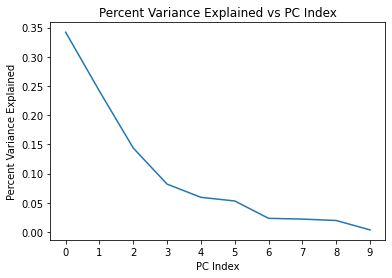

In [118]:
n_components_test=10
pca_data = dru.pca_analysis(
    X,
    n_components=n_components_test,
    plot_sqrt_eigvals=False,
    plot_perc_variance_explained=True
)

X_pca = pca_data["data_proj"]

# Plotting

In [119]:
X_input=X[y!= "Unsure"]
y_input = y[y != "Unsure"]

# a) PCA

In [120]:
sys.path.append('/meshAfterParty/meshAfterParty/')
import datajoint_utils as du
import cell_type_utils as ctu

WARNING - 2022-05-05 14:04:51,955 - _default - No project ID could be determined. Consider running `gcloud config set project` or setting the GOOGLE_CLOUD_PROJECT environment variable


Using default Google credentials. There is no ~/.cloudvolume/secrets/google-secret.json set.


INFO - 2022-05-05 14:04:53,761 - settings - Setting enable_python_native_blobs to True
INFO - 2022-05-05 14:04:53,763 - settings - Setting stores to {'h01_skeletons': {'protocol': 'file', 'location': '/mnt/dj-stor01/microns/h01/skeletons', 'stage': '/mnt/dj-stor01/microns/h01/skeletons'}, 'h01_meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/microns/h01/meshes', 'stage': '/mnt/dj-stor01/microns/h01/meshes'}, 'h01_faces': {'protocol': 'file', 'location': '/mnt/dj-stor01/microns/h01/faces', 'stage': '/mnt/dj-stor01/microns/h01/faces'}, 'h01_decimated_meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/microns/h01/decimated_meshes', 'stage': '/mnt/dj-stor01/microns/h01/decimated_meshes'}, 'h01_soma_meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/microns/h01/soma_meshes', 'stage': '/mnt/dj-stor01/microns/h01/soma_meshes'}}
INFO - 2022-05-05 14:04:53,774 - connection - Connected celiib@at-database.ad.bcm.edu:3306


Connecting celiib@at-database.ad.bcm.edu:3306


INFO - 2022-05-05 14:04:54,864 - settings - Setting enable_python_native_blobs to True
WARNING - 2022-05-05 14:04:58,395 - utils - DataJointPlus version check failed.
INFO - 2022-05-05 14:05:00,013 - settings - Setting enable_python_native_blobs to True
ERROR - 2022-05-05 14:05:00,036 - compatibility - Could not add DataJointPlus to ImportMethod.
Traceback (most recent call last):
  File "/datajoint-plus/datajoint_plus/compatibility.py", line 41, in add_datajoint_plus
    obj.parse_hash_info_from_header()
  File "/datajoint-plus/datajoint_plus/base.py", line 354, in parse_hash_info_from_header
    if result[0] == attr:
IndexError: list index out of range
ERROR - 2022-05-05 14:05:00,086 - compatibility - Could not add DataJointPlus to Materialization.
Traceback (most recent call last):
  File "/datajoint-plus/datajoint_plus/compatibility.py", line 41, in add_datajoint_plus
    obj.parse_hash_info_from_header()
  File "/datajoint-plus/datajoint_plus/base.py", line 354, in parse_hash_info

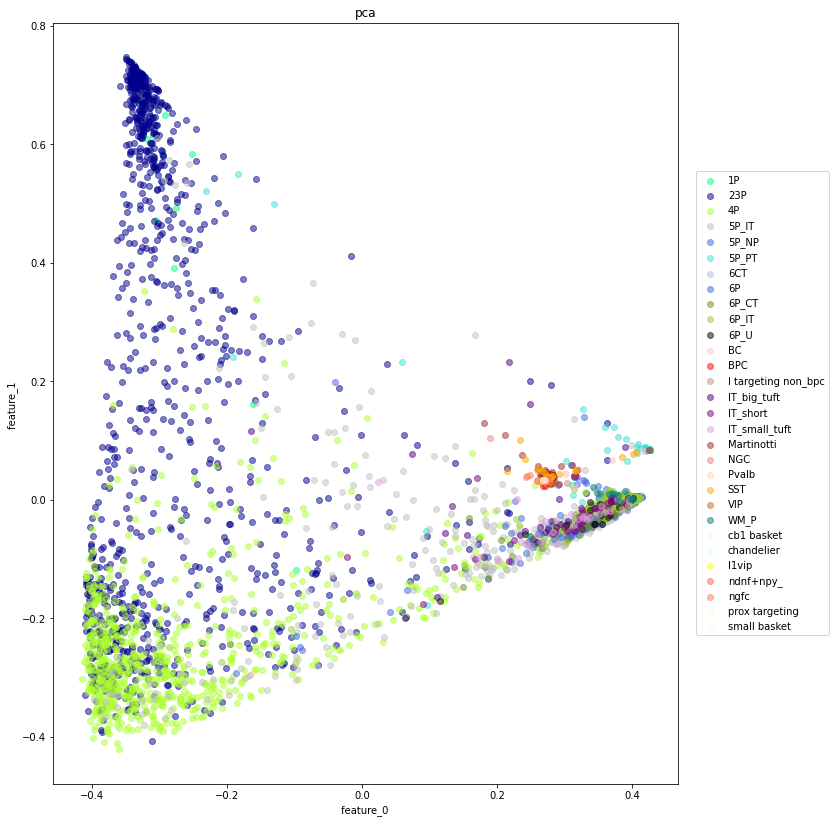

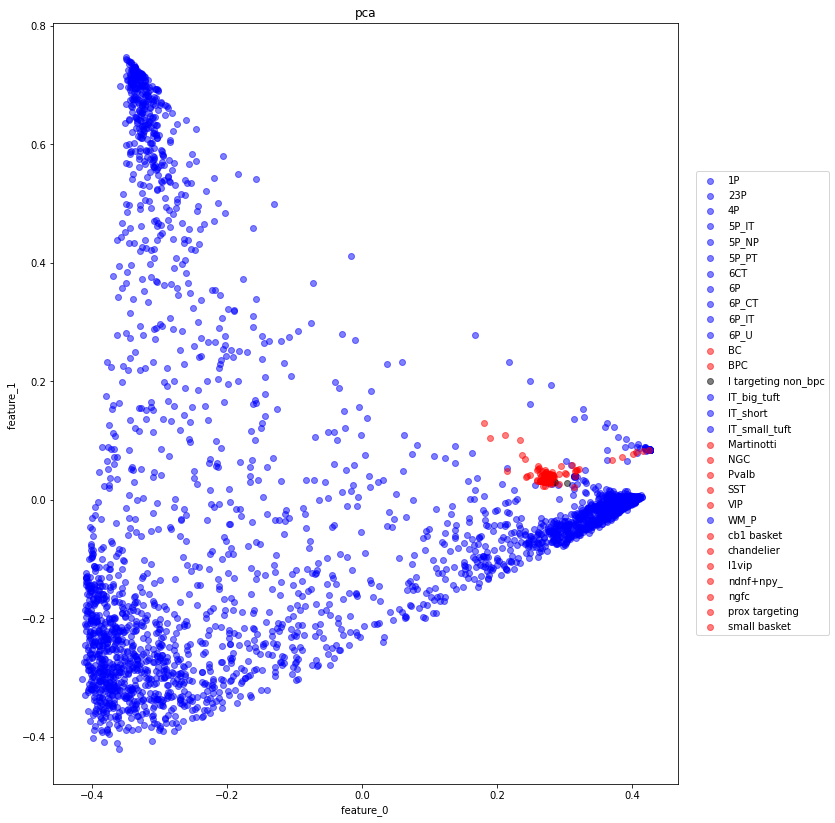

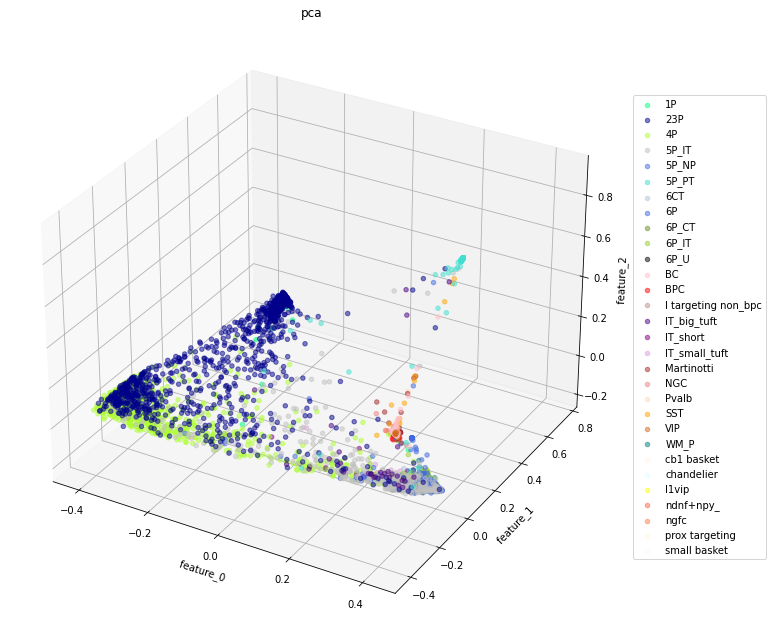

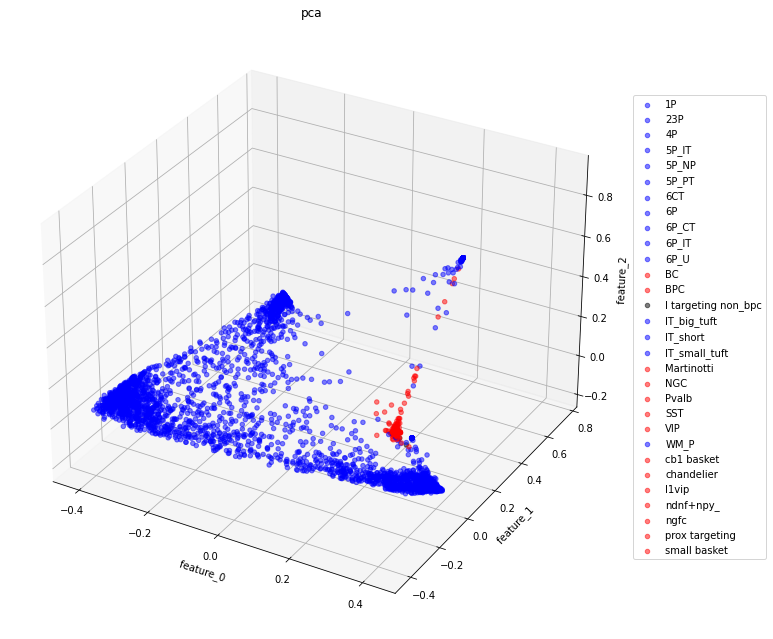

In [121]:
import dimensionality_reduction_ml as dru
import cell_type_utils as ctu
vml.plot_dim_red_analysis(
    X=X_input,
    y=y_input,
    method = "pca",
    color_mapppings = [
        ctu.cell_type_fine_color_map,
        ctu.e_i_color_dict()],
)

In [128]:
y

array(['4P', '23P', '5P_IT', ..., '5P_NP', '6P', 'BPC'], dtype=object)

In [123]:
X_input=X[y!= "Unsure"]
y_input = y[y != "Unsure"]

# b) UMAP (0.5)

/usr/local/lib/python3.6/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9100. The TBB threading layer is disabled.
  warnings.warn(problem)


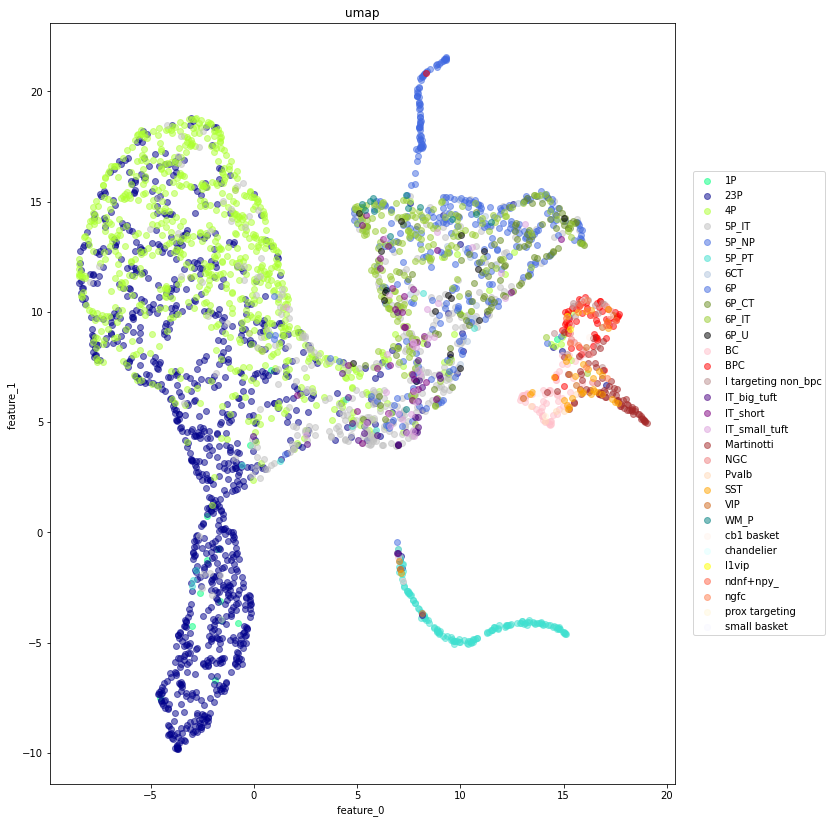

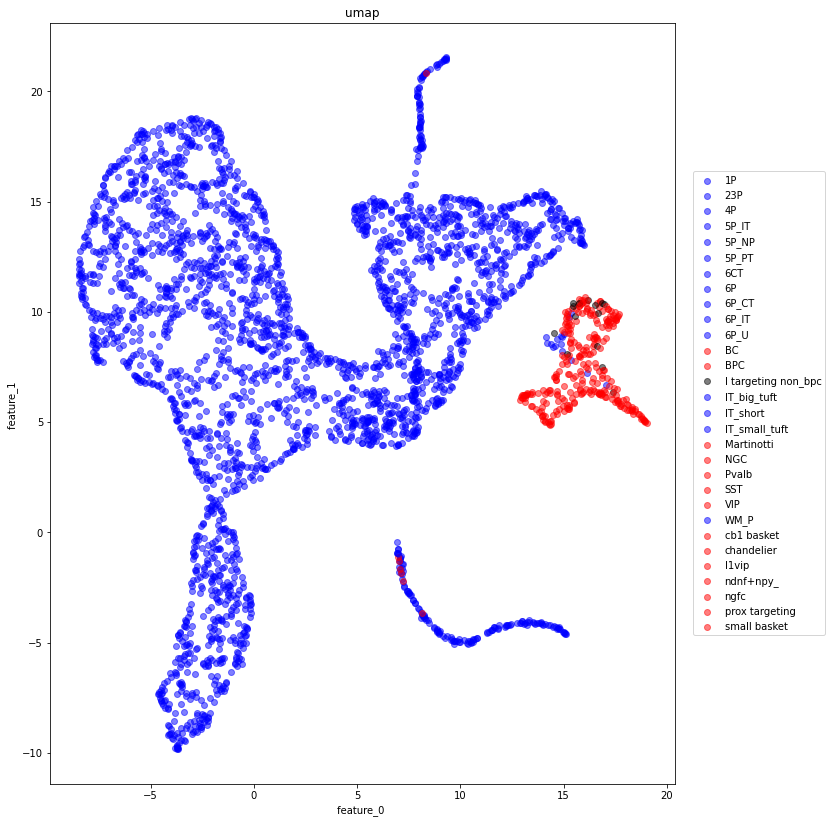

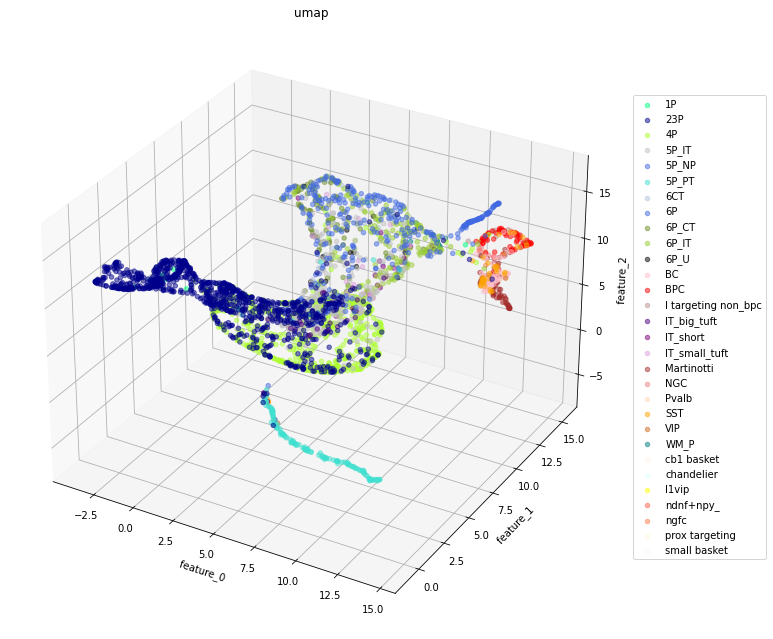

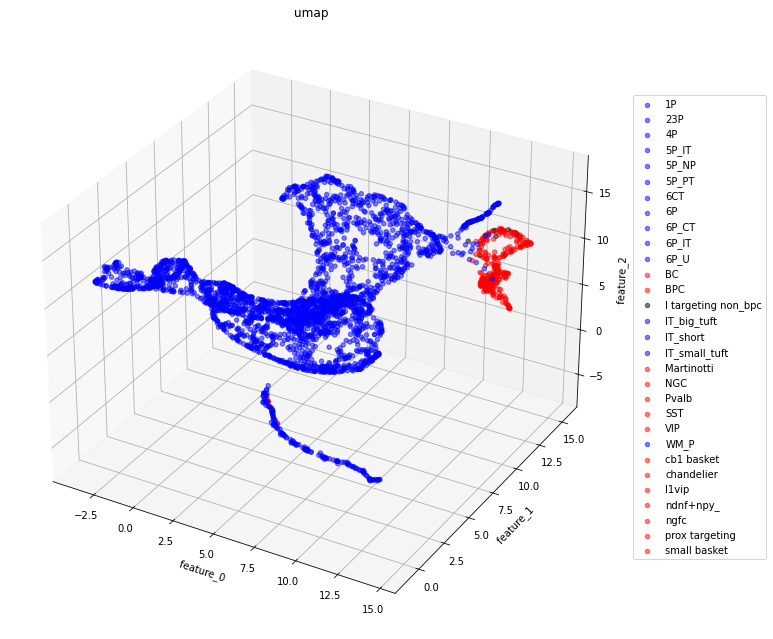

In [124]:
vml.plot_dim_red_analysis(
    X=X_input,
    y=y_input,
    method = "umap",
    color_mapppings = [
        ctu.cell_type_fine_color_map,
        ctu.e_i_color_dict()],
    min_dist = 0.5,
)

# b) UMAP (0.2)

In [125]:
sys.path.append("/meshAfterParty/meshAfterParty/")
import datajoint_utils as du
import cell_type_utils as ctu

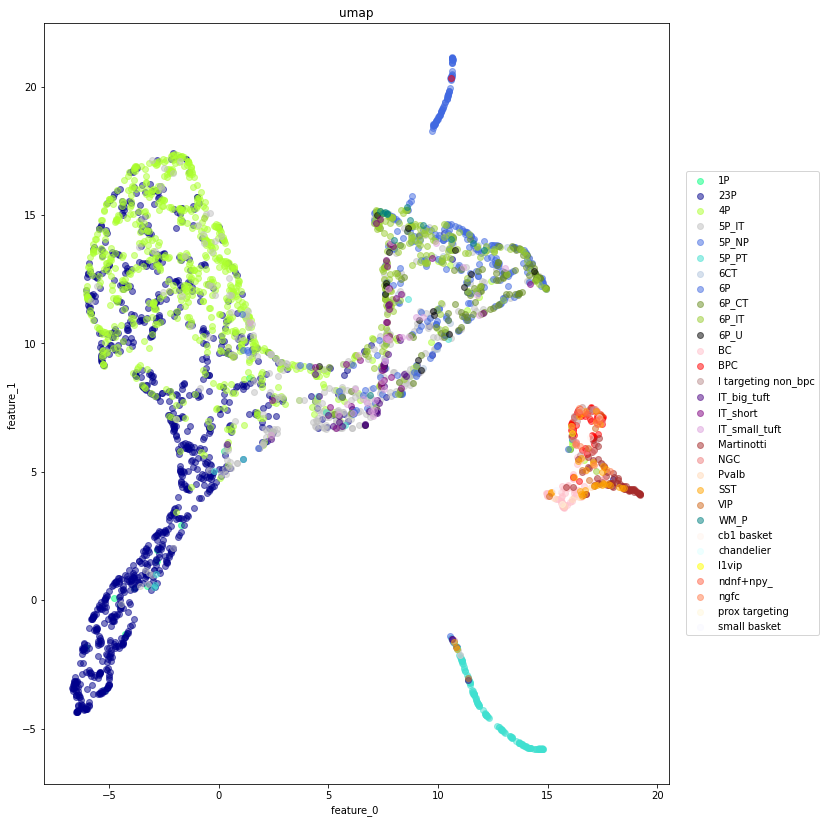

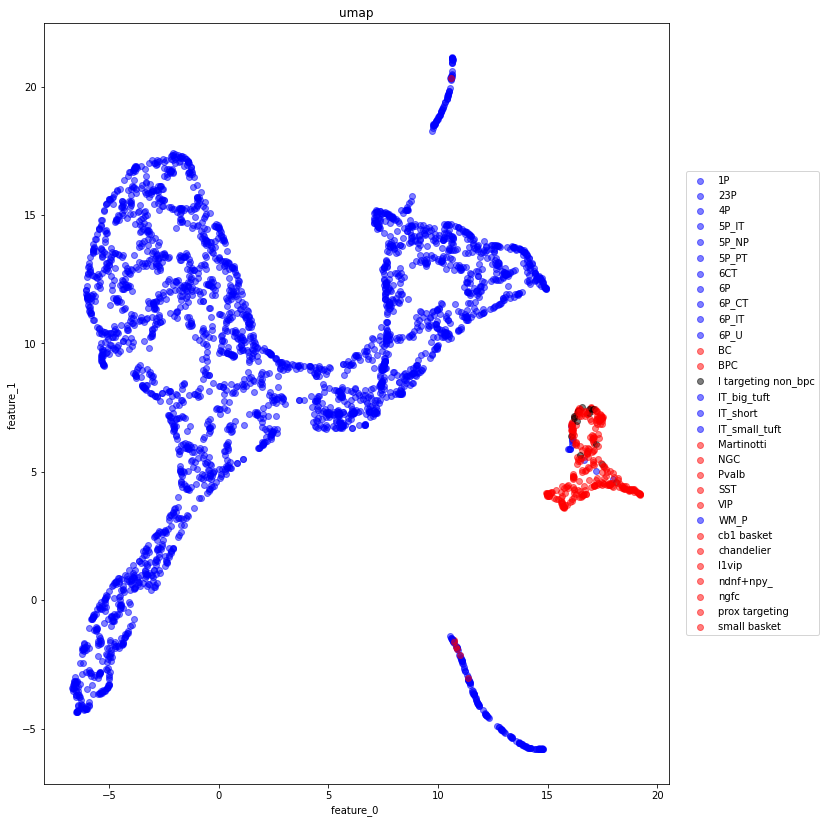

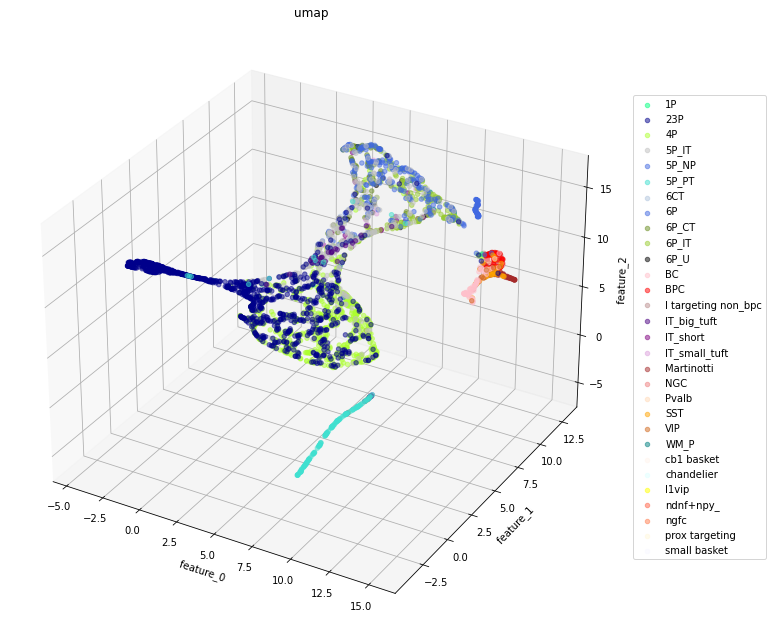

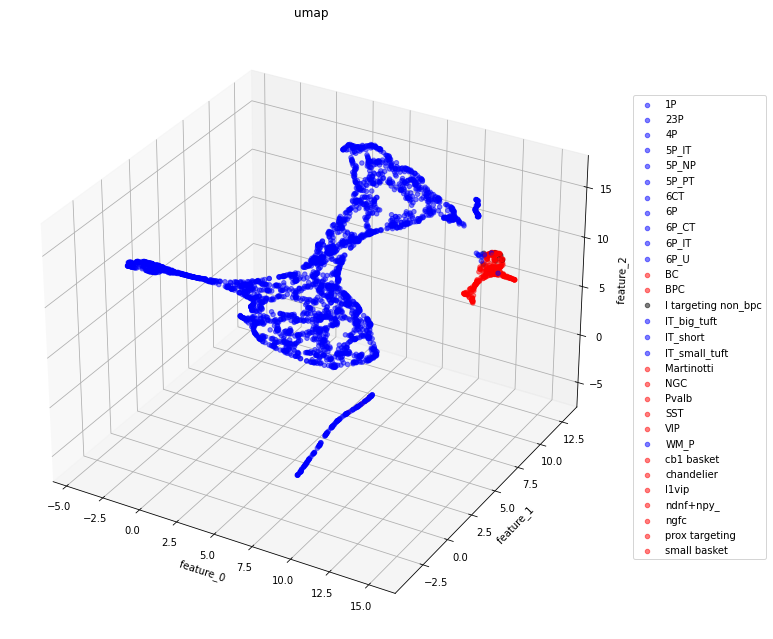

In [126]:
vml.plot_dim_red_analysis(
    X=X_input,
    y=y_input,
    method = "umap",
    color_mapppings = [
        ctu.cell_type_fine_color_map,
        ctu.e_i_color_dict()],
    min_dist = 0.2,
)

# tsne

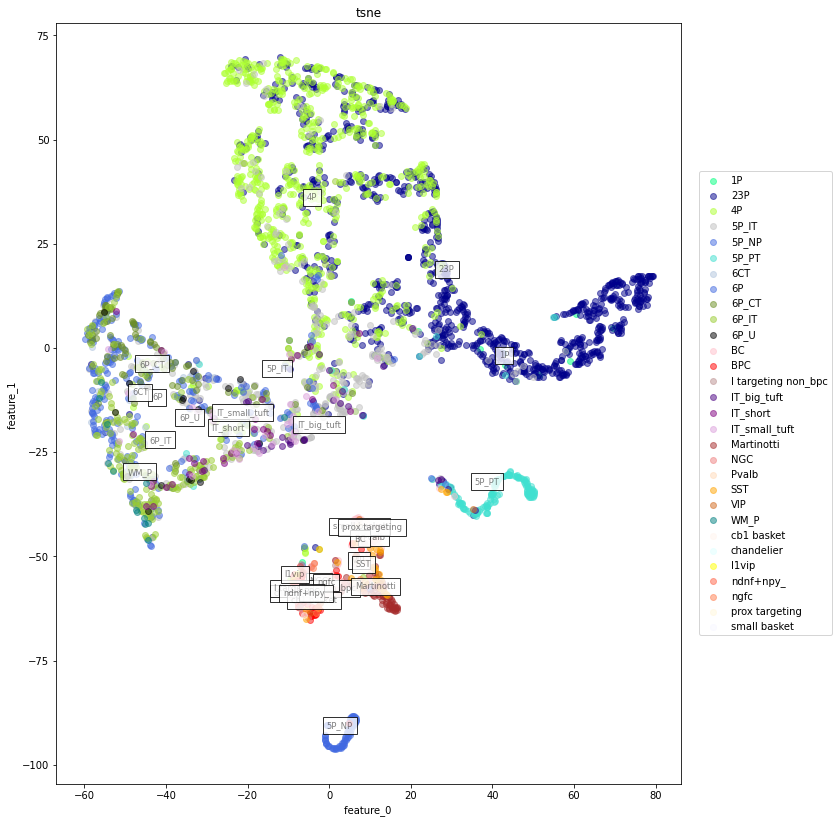

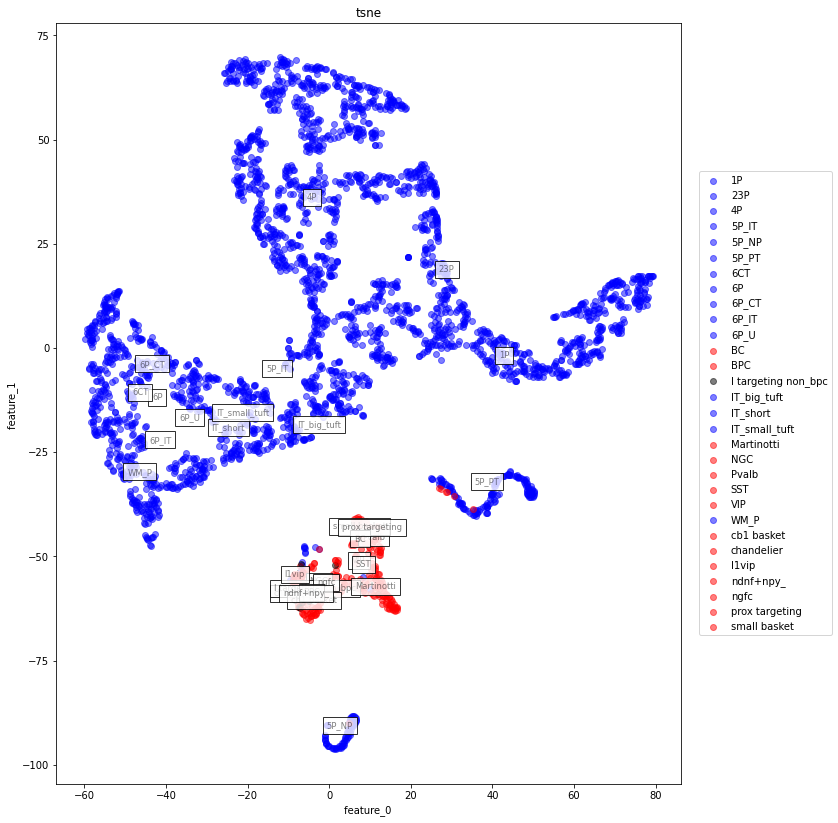

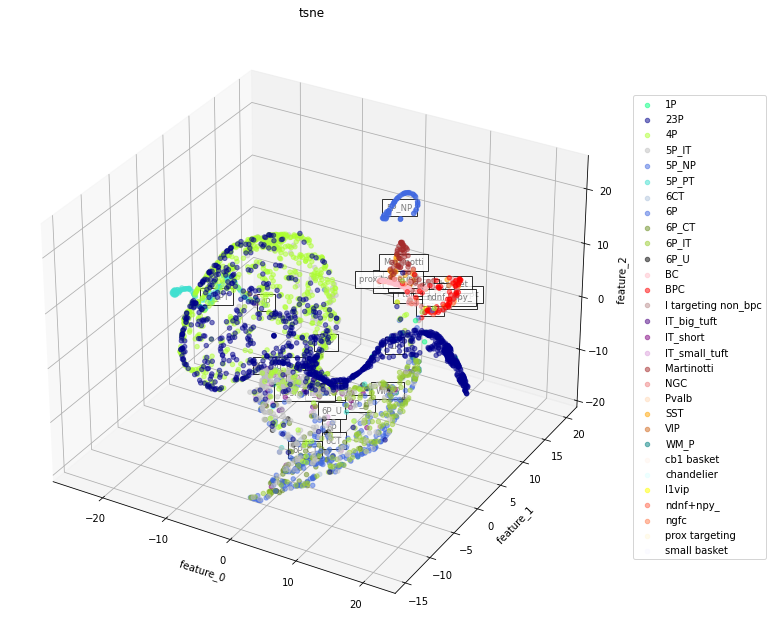

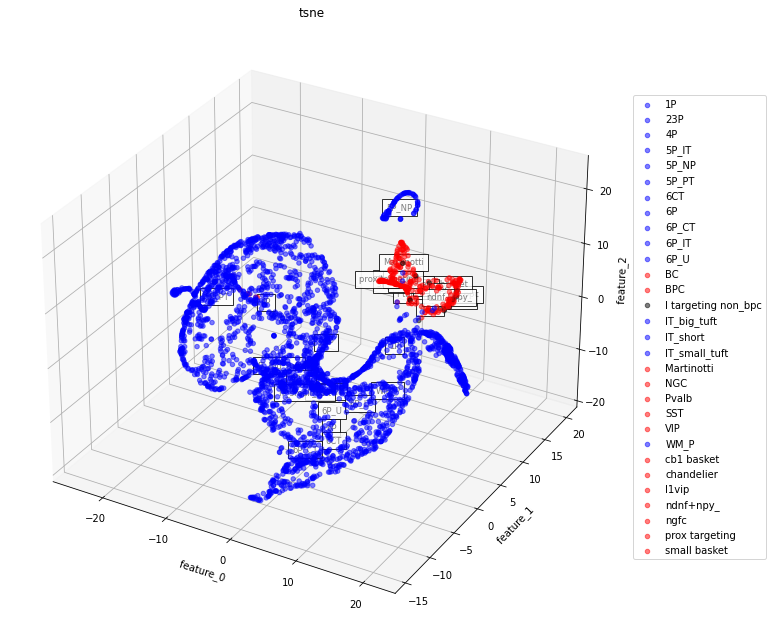

In [131]:
vml.plot_dim_red_analysis(
    X=X_input,
    y=y_input,
    method = "tsne",
    color_mapppings = [
        ctu.cell_type_fine_color_map,
        ctu.e_i_color_dict()],
    #min_dist = 0.2,
    plot_kwargs=dict(use_labels_as_text_to_plot = True)
)

# Computing the Test Accuracy

In [105]:
all_data_loader = data_loader_mod(test_dataset, batch_size=batch_size,shuffle = False)
all_data_loader

model.eval()
embeddings = []
labels = []
for data in tqdm(all_data_loader):#train_loader:  # Iterate in batches over the training dataset.
    data = data.to(device)
    if model_name == "DiffPool":
            out,gnn_loss, cluster_loss = model(data)  # Perform a single forward pass.
            #y_true = data.y.reshape(-1,3)
    elif model_name == "TreeLSTM":
        n = data.x.shape[0]
        h = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
        c = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
        out = model(
            data,
            h = h,
            c = c,
            embeddings = data.x
            )
    else:
        out = model(data)

    out_array = out.detach().cpu().numpy()
    out_labels = data.y.numpy().reshape(-1)
    #print(f"out_array.shape = {out_array.shape}, out_labels.shape = {out_labels.shape}")
    
#     if out_array.shape[0] != out_labels.shape[0]:
#         raise Exception("")
    
    embeddings.append(out_array)
    labels.append(out_labels)
    
    
    
embeddings = np.vstack(embeddings)
labels = np.hstack(labels)

embedding_df = pd.DataFrame(embeddings)
embedding_df["cell_type"] = labels

import general_utils as gu
decoder_map = dict([(v,k) if k is not None else (v,"Unknown") for k,v in cell_type_map.items()])

import pandas_utils as pu
embedding_df["cell_type"] = pu.new_column_from_dict_mapping(embedding_df,decoder_map,column_name = "cell_type")

import pandas_ml as pdml
df_labeled = embedding_df.query("(cell_type!='Unknown') and (cell_type != 'Unsure')")
X,y = pdml.X_y(df_labeled,"cell_type")
class_label_idx = np.argmax(X.to_numpy(),axis=1)
decoder = {v:k for k,v in cell_type_map.items()}
df_labeled["cell_type_predicted"] = [decoder[k] for k in class_label_idx]
df_labeled["e_i_label"] = [ctu.e_i_label_from_cell_type_fine(k) for k in df_labeled["cell_type"].to_numpy()]
df_labeled["e_i_predicted"] = [ctu.e_i_label_from_cell_type_fine(k) for k in df_labeled["cell_type_predicted"].to_numpy()]

accuracy = len(df_labeled.query("cell_type == cell_type_predicted"))/len(df_labeled)
print(f"cell_type_fine test accuracy: {accuracy}")
accuracy = len(df_labeled.query("e_i_label == e_i_predicted"))/len(df_labeled)
print(f"e_i_label test accuracy: {accuracy}")

  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


cell_type_fine test accuracy: 0.4496240601503759
e_i_label test accuracy: 0.9578947368421052


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [136]:
all_data_loader = data_loader_mod(val_dataset, batch_size=batch_size,shuffle = False)
all_data_loader

model.eval()
embeddings = []
labels = []
for data in tqdm(all_data_loader):#train_loader:  # Iterate in batches over the training dataset.
    data = data.to(device)
    if model_name == "DiffPoolGCN":
            out,gnn_loss, cluster_loss = model(data)  # Perform a single forward pass.
            #y_true = data.y.reshape(-1,3)
    elif model_name == "TreeLSTM":
        n = data.x.shape[0]
        h = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
        c = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
        out = model(
            data,
            h = h,
            c = c,
            embeddings = data.x
            )
    else:
        out = model(data)

    out_array = out.detach().cpu().numpy()
    out_labels = data.y.numpy().reshape(-1)
    #print(f"out_array.shape = {out_array.shape}, out_labels.shape = {out_labels.shape}")
    
#     if out_array.shape[0] != out_labels.shape[0]:
#         raise Exception("")
    
    embeddings.append(out_array)
    labels.append(out_labels)
    
    
    
embeddings = np.vstack(embeddings)
labels = np.hstack(labels)

embedding_df = pd.DataFrame(embeddings)
embedding_df["cell_type"] = labels

import general_utils as gu
decoder_map = dict([(v,k) if k is not None else (v,"Unknown") for k,v in cell_type_map.items()])

import pandas_utils as pu
embedding_df["cell_type"] = pu.new_column_from_dict_mapping(embedding_df,decoder_map,column_name = "cell_type")

import pandas_ml as pdml
df_labeled = embedding_df.query("(cell_type!='Unknown') and (cell_type != 'Unsure')")
X,y = pdml.X_y(df_labeled,"cell_type")
class_label_idx = np.argmax(X.to_numpy(),axis=1)
decoder = {v:k for k,v in cell_type_map.items()}
df_labeled["cell_type_predicted"] = [decoder[k] for k in class_label_idx]
df_labeled["e_i_label"] = [ctu.e_i_label_from_cell_type_fine(k) for k in df_labeled["cell_type"].to_numpy()]
df_labeled["e_i_predicted"] = [ctu.e_i_label_from_cell_type_fine(k) for k in df_labeled["cell_type_predicted"].to_numpy()]

accuracy = len(df_labeled.query("cell_type == cell_type_predicted"))/len(df_labeled)
print(f"cell_type_fine test accuracy: {accuracy}")
accuracy = len(df_labeled.query("e_i_label == e_i_predicted"))/len(df_labeled)
print(f"e_i_label test accuracy: {accuracy}")

  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

cell_type_fine test accuracy: 0.5535444947209653
e_i_label test accuracy: 0.9743589743589743


In [134]:
out

(tensor([[3.1085e-04, 1.4844e-02, 1.5164e-01,  ..., 1.3587e-04, 2.2237e-04,
          5.1964e-05],
         [1.6905e-04, 5.4255e-03, 2.2410e-01,  ..., 3.9161e-04, 9.1293e-05,
          1.6284e-04],
         [2.5713e-04, 1.1155e-03, 4.5125e-03,  ..., 4.2500e-04, 5.7908e-04,
          2.7352e-04],
         ...,
         [2.7780e-04, 4.7257e-03, 1.4095e-01,  ..., 6.4786e-04, 2.4102e-04,
          3.1854e-04],
         [3.6967e-04, 6.0646e-04, 7.3061e-04,  ..., 6.1556e-03, 1.6757e-03,
          5.4299e-03],
         [1.3074e-04, 7.2099e-04, 7.6077e-03,  ..., 1.5383e-04, 1.9932e-04,
          8.8548e-05]], grad_fn=<SoftmaxBackward0>),
 tensor(2.9009e-05, grad_fn=<DivBackward0>),
 tensor(0.5557, grad_fn=<MeanBackward0>))